In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
val_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

In [8]:
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
val_dataset = datasets.STL10(root='./data', split='test', download=True, transform=val_transform)

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

torch.Size([128, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


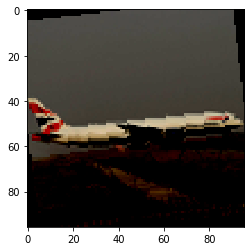

In [10]:
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
print(imgs.size())
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
plt.imshow(imgs[0].permute(1,2,0))

In [13]:
model = models.vgg16(pretrained = True)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
model.classifier[6] = nn.Linear(4096,10)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.0001)

In [18]:
%%time
num_epochs = 15
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    model.train()

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        train_acc += (pred == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
          
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)
          
          val_loss += loss.item()
          pred = torch.argmax(outputs, dim=1)
          val_acc += (pred == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
        
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/15], Loss: 0.0198, val_loss: 0.0170, val_acc: 0.2283
Epoch [2/15], Loss: 0.0183, val_loss: 0.0156, val_acc: 0.3370
Epoch [3/15], Loss: 0.0172, val_loss: 0.0144, val_acc: 0.4320
Epoch [4/15], Loss: 0.0162, val_loss: 0.0133, val_acc: 0.5218
Epoch [5/15], Loss: 0.0151, val_loss: 0.0124, val_acc: 0.5926
Epoch [6/15], Loss: 0.0143, val_loss: 0.0116, val_acc: 0.6478
Epoch [7/15], Loss: 0.0134, val_loss: 0.0109, val_acc: 0.6909
Epoch [8/15], Loss: 0.0127, val_loss: 0.0103, val_acc: 0.7186
Epoch [9/15], Loss: 0.0124, val_loss: 0.0097, val_acc: 0.7428
Epoch [10/15], Loss: 0.0119, val_loss: 0.0092, val_acc: 0.7598
Epoch [11/15], Loss: 0.0115, val_loss: 0.0088, val_acc: 0.7736
Epoch [12/15], Loss: 0.0110, val_loss: 0.0084, val_acc: 0.7830
Epoch [13/15], Loss: 0.0106, val_loss: 0.0081, val_acc: 0.7914
Epoch [14/15], Loss: 0.0103, val_loss: 0.0078, val_acc: 0.7980
Epoch [15/15], Loss: 0.0100, val_loss: 0.0075, val_acc: 0.8027
CPU times: user 4min 17s, sys: 0 ns, total: 4min 17s
Wall time: 

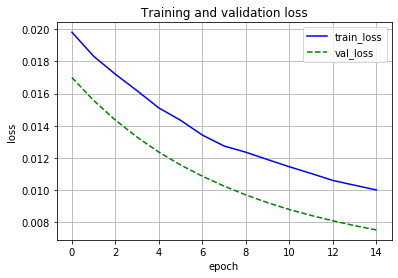

In [19]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

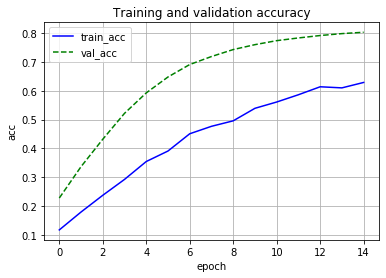

In [20]:
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()